# MsFEM: Offline Space

In [1]:
import math
import scipy.linalg
import scipy.sparse
import numpy as np

from ufl import *
from dolfin import *
from utils import *

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from gmsfem import MsFEM

In [6]:
rank = 3
for i in range(rank, 7, 4):
    print(i)

3


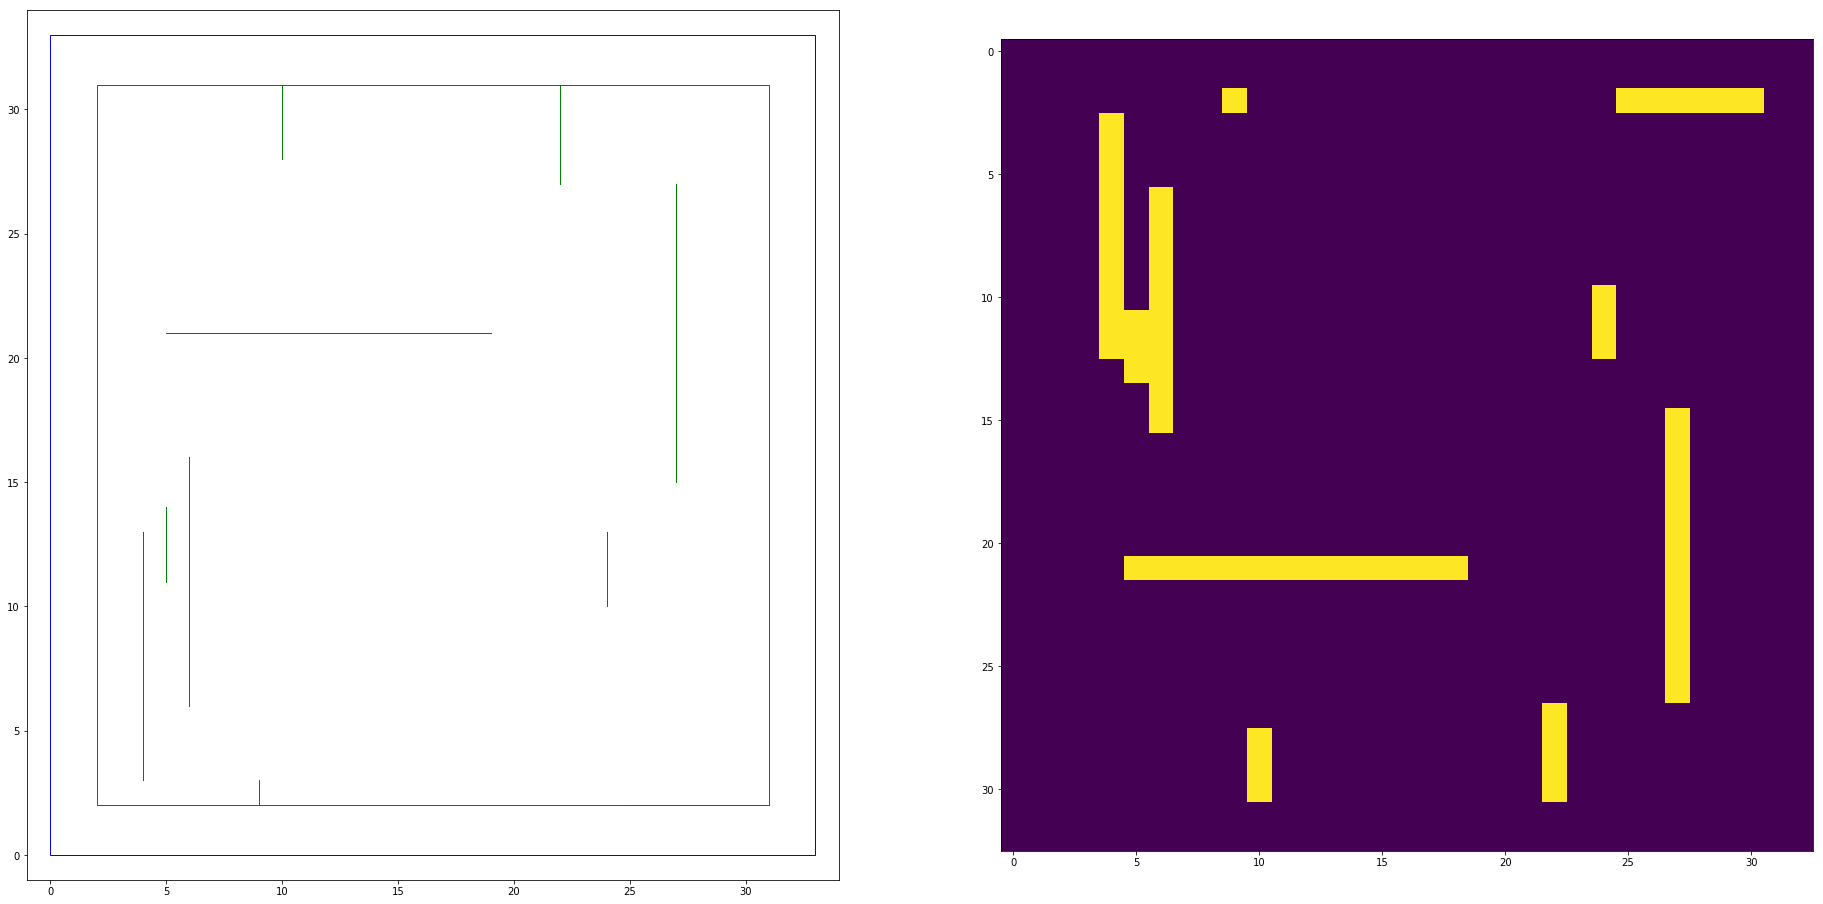

In [3]:
# Mask Generation
N_el = 32
win = N_el // 16
side = N_el + 1 - 2*win

n_strips = N_el // 3
n_ver = np.random.binomial(n_strips, p=.5)
n_hor = n_strips - n_ver

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))
ax1.set_xlim(-1, N_el+2)
ax1.set_ylim(-1, N_el+2)
ax1.add_patch(Rectangle((0, 0), N_el+1, N_el+1, lw=1, fc='none', ec='b'));
ax1.add_patch(Rectangle((win, win), side, side, lw=1, fc='none', ec='r'));

mask = np.zeros((N_el+1, N_el+1), dtype='bool')
for pos, n_lines in zip((0, 1), (n_ver, n_hor)):
    ends = [None] * 2
    ends[0] = np.random.choice(side, n_lines, replace=False) + win
    ends[1] = np.random.choice(side, n_lines, replace=False) + win
    lengths = np.ceil(np.random.rand(n_lines) * (side+win-ends[pos])).astype('int')
    for l, x1, x2 in zip(lengths, *ends):
        if pos:
        # vertical lines
            xdata = [x1] 
            ydata = [x2, x2+l]
            mask[x2:x2+l, x1] = True
        else: 
        # horizontal lines
            xdata = [x1, x1+l]
            ydata = [x2]
            mask[x2, x1:x1+l] = True

        ax1.add_line(Line2D(xdata, ydata, lw=1, c='g'))
ax2.imshow(mask);

In [4]:
K = get_simple_kappa([10, 100, 1000, 4000], 32)

In [7]:
Function().vector().get_local()

IndexError: tuple index out of range

In [12]:
def set_kappa(eta, mask, V):
    """
    Set permeability coefficient
    """
    kappa = Function(V)
    v2d = vertex_to_dof_map(V)
    dofs, = mask.flatten().nonzero()
    kappa.vector()[:] = 1
    kappa.vector()[v2d[dofs]] = eta
    
    return kappa

tol = 1./N_el
def set_boundary(p, src):
    """
    Delta function bc
    """
    predicate_1 = near(p[0], src[0], tol)
    predicate_2 = near(p[1], src[1], tol)

    return predicate_1 and predicate_2

mesh = UnitSquareMesh(N_el, N_el)
V = FunctionSpace(mesh, 'P', 1)
u = TrialFunction(V)
v = TestFunction(V)
#kappa = set_kappa(1e2, mask, V)

a = dot(grad(u), grad(v)) * dx
#a = kappa * dot(grad(u), grad(v)) * dx
L = Constant(0.) * v * dx
A = assemble(a)
b = assemble(L)

U, DU = [], []
bmesh = BoundaryMesh(mesh, 'local')
build = np.vectorize(assemble, [float])
every = lambda x, on: on

for src in bmesh.coordinates():
    single = lambda x: set_boundary(x, src)
    bc1 = DirichletBC(V, Constant(0.), every)
    bc2 = DirichletBC(V, Constant(1.), single, 'pointwise')
    bcs = [bc1, bc2]
    
    b_loc = b.copy()
    A_loc = A.copy()
    for bc in bcs:
        bc.apply(A_loc, b_loc)

    u = Function(V)
    solve(A_loc, u.vector(), b_loc)
    U.append(u)
    DU.append(grad(u))

A = build(np.outer(U, U) * dx)  # mass matrix
S = build(np.tensordot(DU, DU, [1, 1]) * dx)  # stiffness matrix
# A = build(kappa * np.outer(U, U) * dx)
# S = build(kappa * np.tensordot(DU, DU, [1, 1]) * dx)
w, v = scipy.linalg.eigh(A, S)

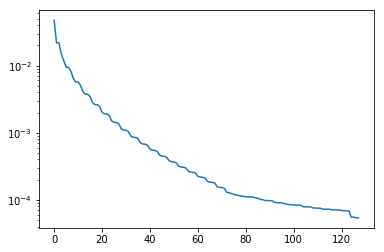

In [13]:
plt.plot(w[::-1])
plt.yscale('log')

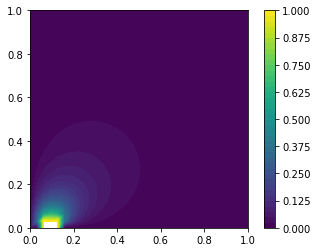

In [14]:
p = plot(U[4])
plt.colorbar(p)

In [3]:
def setKappa(eta, mask, V):
    kappa = Function(V)
    v2d = vertex_to_dof_map(V)
    dofs, = mask.flatten().nonzero()
    kappa.vector()[:] = 1
    kappa.vector()[v2d[dofs]] = eta
    
    return kappa

tol = 1./N_el
def boundary_1(p, src):
        predicat_1 = near(p[0], src[0], tol)
        predicat_2 = near(p[1], src[1], tol)

        return predicat_1 and predicat_2

In [5]:
n_el = 8  #  number of elements in a coarse block 
n_blocks = 4  #  number of coarse blocks along 1D
N_el = n_el * n_blocks  #  number of total elements along an axis
eta = 1e3

mom_mesh = MultiMesh()
for index in range((n_blocks-1)*(n_blocks-1)):
    i = index // (n_blocks-1)
    j = index % (n_blocks-1)
    NBH = UnitSquareMesh(2*n_el, 2*n_el)
    NBH.translate(Point(j*.5, i*.5))
    NBH.scale(2./n_blocks)
    mom_mesh.add(NBH)
mom_mesh.build()
W = MultiMeshFunctionSpace(mom_mesh, 'P', 1)
v = MultiMeshFunction(W)

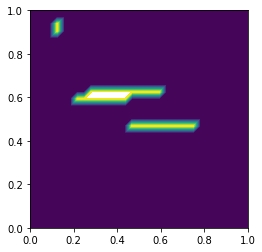

In [7]:
ms_solver = MsFEM(n_el, n_blocks, N_el//8, 10, seed=123)
u = ms_solver.getFineMeshSolution()
plot(ms_solver._kappa[-1])

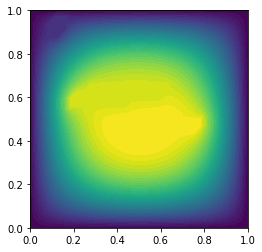

In [4]:
plot(u)

In [8]:
M = ms_solver.M_off
N_c = len(ms_solver.V)
n_c = int(N_c**.5)

I = np.arange(N_c-n_c)
pairs = np.column_stack((I, I+n_c))

I = np.arange(N_c).reshape(n_c, n_c)[:, :-1].flatten()
new_pairs = np.column_stack((I, I+1))
pairs = np.row_stack((pairs, new_pairs))

I = np.arange(N_c-n_c).reshape(n_c-1, n_c)[:, :-1].flatten()
new_pairs = np.column_stack((I, I+n_c+1))
pairs = np.row_stack((pairs, new_pairs))

I = np.arange(N_c-n_c).reshape(n_c-1, n_c)[:, 1:].flatten()
new_pairs = np.column_stack((I, I+n_c-1))
pairs = np.row_stack((pairs, new_pairs))

In [9]:
pairs

array([[0, 3],
       [1, 4],
       [2, 5],
       [3, 6],
       [4, 7],
       [5, 8],
       [0, 1],
       [1, 2],
       [3, 4],
       [4, 5],
       [6, 7],
       [7, 8],
       [0, 4],
       [1, 5],
       [3, 7],
       [4, 8],
       [1, 3],
       [2, 4],
       [4, 6],
       [5, 7]])

In [47]:
np.array()

array([3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 2, 2, 2, 2])

In [5]:
%%time
ms_solver.buildSnapshotSpace()
ms_solver.buildOfflineSpace()

CPU times: user 1min 54s, sys: 1.5 s, total: 1min 55s
Wall time: 1min 53s


In [6]:
%%time
out = ms_solver.globalCoupling()

CPU times: user 11.9 s, sys: 74.8 ms, total: 12 s
Wall time: 12 s


In [7]:
dx = Measure('dx', domain=ms_solver.V[0])
v = TestFunction(ms_solver.V[0])
assemble(ms_solver._rhs * v * dx).get_local()

array([ 0.0001277 ,  0.0003838 ,  0.00038985,  0.0003828 ,  0.00078277,
        0.00040117,  0.00038106,  0.00078049,  0.00080524,  0.00041202,
        0.0003786 ,  0.0007767 ,  0.00080289,  0.00082674,  0.00042233,
        0.00037541,  0.00077142,  0.00079899,  0.00082433,  0.00084716,
        0.00043206,  0.00037152,  0.00076468,  0.00079356,  0.00082032,
        0.00084469,  0.00086639,  0.00044115,  0.00036696,  0.00075652,
        0.00078663,  0.00081474,  0.00084058,  0.00086386,  0.00088433,
        0.00044956,  0.00036175,  0.00074699,  0.00077823,  0.00080763,
        0.00083487,  0.00085966,  0.00088175,  0.00090088,  0.00045723,
        0.00035591,  0.00073614,  0.00076843,  0.00079901,  0.00082757,
        0.00085381,  0.00087746,  0.00089825,  0.00091595,  0.00046412,
        0.00034949,  0.00072404,  0.00075727,  0.00078894,  0.00081874,
        0.00084635,  0.00087149,  0.00089388,  0.00091327,  0.00092945,
        0.0004702 ,  0.00034251,  0.00071074,  0.00074482,  0.00

In [26]:
A, b, psi = out

In [20]:
b[0]

array([  3.79107393e-05,  -2.20912592e-03,   1.05478230e-03,
         1.63882891e-06,   4.78235377e-06,  -2.69370700e-03,
        -6.20813226e-03,   3.98206294e-06,   5.80310321e-02,
         2.43621546e-02,   2.55478320e-04,  -1.82328199e-03,
         1.83712515e-03,   2.36662785e-03,   2.40951601e-03,
         8.72275276e-03,  -5.76637598e-04,  -1.65816031e-03,
         2.94624825e-02,  -4.04483013e-02,  -6.64662456e-04,
         1.93670270e-03,   1.33690190e-03,   2.26895349e-03,
        -3.08439527e-03,   1.00087277e-03,   7.79256769e-03,
        -6.98248061e-04,   9.26652582e-03,  -4.75094698e-02,
        -3.48987327e-04,  -3.50323945e-03,  -5.42190117e-03,
        -2.65969036e-03,   1.68570256e-04,   1.01631424e-02,
         2.67792571e-03,  -3.49127216e-02,   1.30879437e-02,
        -4.69755017e-02,  -9.69465160e-04,  -1.17188420e-03,
         6.36869999e-03,  -2.56719647e-03,  -2.65169334e-03,
         1.02785580e-02,   5.61677416e-03,   2.40349118e-02,
         1.06661113e-02,

In [21]:
b[0] - b[2][0]

array([  1.06961185e-05,  -2.23634054e-03,   1.02756768e-03,
        -2.55757919e-05,  -2.24322670e-05,  -2.72092162e-03,
        -6.23534688e-03,  -2.32325578e-05,   5.80038175e-02,
         2.43349400e-02,   2.28263699e-04,  -1.85049661e-03,
         1.80991053e-03,   2.33941323e-03,   2.38230139e-03,
         8.69553814e-03,  -6.03852218e-04,  -1.68537493e-03,
         2.94352679e-02,  -4.04755159e-02,  -6.91877076e-04,
         1.90948808e-03,   1.30968728e-03,   2.24173887e-03,
        -3.11160989e-03,   9.73658149e-04,   7.76535307e-03,
        -7.25462682e-04,   9.23931120e-03,  -4.75366844e-02,
        -3.76201948e-04,  -3.53045407e-03,  -5.44911579e-03,
        -2.68690498e-03,   1.41355635e-04,   1.01359278e-02,
         2.65071109e-03,  -3.49399362e-02,   1.30607291e-02,
        -4.70027163e-02,  -9.96679781e-04,  -1.19909882e-03,
         6.34148537e-03,  -2.59441109e-03,  -2.67890796e-03,
         1.02513433e-02,   5.58955954e-03,   2.40076972e-02,
         1.06388967e-02,

In [11]:
b[2]

array([  2.72146208e-05,  -2.25793170e-03,   1.77228328e-03,
         4.92770591e-06,   1.95708412e-06,  -3.25432414e-03,
        -7.95612427e-03,   6.61872016e-06,   5.98600846e-02,
         2.70134491e-02,   2.91211938e-04,  -2.16245307e-03,
         2.91354005e-03,   2.32036831e-03,   2.95139022e-03,
         1.06211746e-02,  -6.46431606e-04,  -2.20040743e-03,
         3.06847840e-02,  -4.23531332e-02,  -4.67575578e-04,
         2.05538831e-03,   2.01998941e-03,   2.60438628e-03,
        -3.73401692e-03,   1.17887771e-03,   8.96025435e-03,
        -1.46563279e-03,   9.28368671e-03,  -4.86726968e-02,
        -6.00917527e-04,  -4.77749895e-03,  -6.47866377e-03,
        -3.91326305e-03,   7.15706086e-04,   1.18182388e-02,
         1.95981493e-03,  -3.69013054e-02,   1.43390027e-02,
        -4.92007570e-02,  -1.07687215e-03,  -1.74335184e-03,
         7.98592091e-03,  -2.27620121e-03,  -3.65945370e-03,
         1.24113617e-02,   6.53424368e-03,   2.70440729e-02,
         1.10882314e-02,

In [12]:
b[3]

array([ -2.80021157e-05,  -2.29163883e-03,   2.45560025e-03,
        -4.42985391e-04,   6.62679756e-04,  -1.00077855e-03,
        -4.22018150e-03,  -6.12564880e-04,   5.69586448e-02,
         2.11945238e-02,   2.73535287e-04,  -1.66792632e-03,
         3.14657364e-03,   1.47955475e-03,   1.43300694e-03,
         7.32515443e-03,  -4.99305529e-04,   9.47851492e-05,
         3.06911223e-02,  -4.11180148e-02,  -1.16907971e-03,
         1.80207172e-03,   2.29211002e-03,   1.15130166e-03,
        -2.33493382e-03,   6.64006790e-04,   3.22269283e-03,
        -4.16629054e-05,   1.03636379e-02,  -4.92849714e-02,
        -4.61302955e-05,  -3.61062125e-03,  -4.73126086e-03,
        -3.44619854e-03,   3.83662331e-04,   1.07940905e-02,
         5.80478829e-03,  -3.36341072e-02,   1.21873595e-02,
        -4.49842379e-02,  -1.36447513e-03,  -2.15696751e-03,
         6.87019124e-03,  -2.18899736e-03,  -3.58460301e-03,
         1.02507415e-02,   6.28287973e-03,   2.31854839e-02,
         1.03546790e-02,

In [34]:
b[3]

array([ -2.80021157e-05,  -2.29163883e-03,   2.45560025e-03,
        -4.42985391e-04,   6.62679756e-04,  -1.00077855e-03,
        -4.22018150e-03,  -6.12564880e-04,   5.69586448e-02,
         2.11945238e-02,   2.73535287e-04,  -1.66792632e-03,
         3.14657364e-03,   1.47955475e-03,   1.43300694e-03,
         7.32515443e-03,  -4.99305529e-04,   9.47851492e-05,
         3.06911223e-02,  -4.11180148e-02,  -1.16907971e-03,
         1.80207172e-03,   2.29211002e-03,   1.15130166e-03,
        -2.33493382e-03,   6.64006790e-04,   3.22269283e-03,
        -4.16629054e-05,   1.03636379e-02,  -4.92849714e-02,
        -4.61302955e-05,  -3.61062125e-03,  -4.73126086e-03,
        -3.44619854e-03,   3.83662331e-04,   1.07940905e-02,
         5.80478829e-03,  -3.36341072e-02,   1.21873595e-02,
        -4.49842379e-02,  -1.36447513e-03,  -2.15696751e-03,
         6.87019124e-03,  -2.18899736e-03,  -3.58460301e-03,
         1.02507415e-02,   6.28287973e-03,   2.31854839e-02,
         1.03546790e-02,

Calling FFC just-in-time (JIT) compiler, this may take some time.


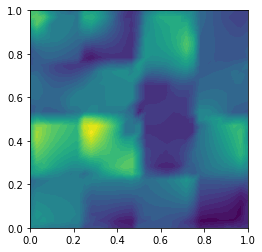

In [30]:
_b = b[3]
u = np.linalg.solve(A, _b)
ans = project((u * psi.flatten()).sum(), ms_solver.W)
plot(ans)

In [23]:
f = project(ms_solver._rhs, ms_solver.V[0])
psi = project(ms_solver.psi_ms[0][0], ms_solver.V[0])
assemble(f * psi * dx)

3.791073932852407e-05

In [19]:
M = ms_solver.M_off
N_c = len(ms_solver.V)
n_c = int(N_c**.5)

b = []
for i in range(N_c):
    dx = Measure('dx', domain=ms_solver.V[i])
    b.append(np.vectorize(assemble, [float])(ms_solver._rhs * ms_solver.psi_ms[i] * dx))


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

In [22]:
b = np.array(b)

In [24]:
b.flatten()

array([  3.79107393e-05,  -2.20912592e-03,   1.05478230e-03,
         1.63882891e-06,   4.78235377e-06,  -2.69370700e-03,
        -6.20813226e-03,   3.98206294e-06,   5.80310321e-02,
         2.43621546e-02,   2.55478320e-04,  -1.82328199e-03,
         1.83712515e-03,   2.36662785e-03,   2.40951601e-03,
         8.72275276e-03,  -5.76637598e-04,  -1.65816031e-03,
         2.94624825e-02,  -4.04483013e-02,  -6.64662456e-04,
         1.93670270e-03,   1.33690190e-03,   2.26895349e-03,
        -3.08439527e-03,   1.00087277e-03,   7.79256769e-03,
        -6.98248061e-04,   9.26652582e-03,  -4.75094698e-02,
        -3.48987327e-04,  -3.50323945e-03,  -5.42190117e-03,
        -2.65969036e-03,   1.68570256e-04,   1.01631424e-02,
         2.67792571e-03,  -3.49127216e-02,   1.30879437e-02,
        -4.69755017e-02,  -9.69465160e-04,  -1.17188420e-03,
         6.36869999e-03,  -2.56719647e-03,  -2.65169334e-03,
         1.02785580e-02,   5.61677416e-03,   2.40349118e-02,
         1.06661113e-02,

In [35]:
M = ms_solver.M_off
N_c = len(ms_solver.V)
n_c = int(N_c**.5)

psi = np.vectorize(project, otypes=['O'])(ms_solver.psi_ms, np.array(ms_solver.V)[:, None])

for i in range(N_c):
    chi = ms_solver._overlap(i, i)
    dx = Measure('dx', domain=ms_solver.W, subdomain_data=chi)
    form = lambda u, v: assemble(ms_solver._kappa[-1] * dot(grad(u), grad(v)) * dx(1))
    A_ii = np.vectorize(form, [float])(psi[i][None], psi[i][:, None])

Calling FFC just-in-time (JIT) compiler, this may take some time.


------------------- Start compiler output ------------------------
/tmp/tmpfp7fuwgn/ffc_form_ed28bf0f1ebe33286b2dbbc38efb64a13c4314a0.cpp: In member function ‘virtual void ffc_form_ed28bf0f1ebe33286b2dbbc38efb64a13c4314a0_cell_integral_main_1::tabulate_tensor(double*, const double* const*, const double*, int) const’:
/tmp/tmpfp7fuwgn/ffc_form_ed28bf0f1ebe33286b2dbbc38efb64a13c4314a0.cpp:105:18: error: redeclaration of ‘const double J_c0’
     const double J_c0 = coordinate_dofs[0] * FE7_C0_D01_Q1[0][0][0] + coordinate_dofs[2] * FE7_C0_D01_Q1[0][0][1];
                  ^~~~
/tmp/tmpfp7fuwgn/ffc_form_ed28bf0f1ebe33286b2dbbc38efb64a13c4314a0.cpp:95:18: note: ‘const double J_c0’ previously declared here
     const double J_c0 = coordinate_dofs[0] * FE7_C0_D01_Q1[0][0][0] + coordinate_dofs[2] * FE7_C0_D01_Q1[0][0][1];
                  ^~~~
/tmp/tmpfp7fuwgn/ffc_form_ed28bf0f1ebe33286b2dbbc38efb64a13c4314a0.cpp:106:18: error: redeclaration of ‘const double J_c3’
     const double J_c3 = coo

DijitsoError: Dijitso JIT compilation failed, see '/home/fenics/shared/src/jitfailure-ffc_form_ed28bf0f1ebe33286b2dbbc38efb64a13c4314a0' for details

In [19]:
M = ms_solver.M_off
N_c = len(ms_solver.V)
n_c = int(N_c**.5)

psi = np.vectorize(project, otypes=['O'])(ms_solver.psi_ms, np.array(ms_solver.V)[:, None])

for i in range(N_c):
    dx = Measure('dx', domain=ms_solver.V[i])
    form = lambda u, v: assemble(ms_solver._kappa[i] * dot(grad(u), grad(v)) * dx)
    A_ii = np.vectorize(form, [float])(psi[i][None], psi[i][:, None])

In [40]:
M = ms_solver.M_off
N_c = len(ms_solver.V)
n_c = int(N_c**.5)

C = np.empty((N_c, M, ms_solver.V[0].dim()))
for i, V in enumerate(ms_solver.V):
    for j in range(M):
        psi = project(ms_solver.psi_ms[i][j], V)
        C[i][j] = psi.compute_vertex_values()

K = ms_solver.V[0].dim()
k = int(K**.5)
I = np.arange(K).reshape(k, k)

v2d = vertex_to_dof_map(ms_solver.V[0])
d2v = dof_to_vertex_map(ms_solver.V[0])
cut_r = I[:, k//2:].flatten()
cut_l = I[:, :k//2+1].flatten()
cut_br = I[k//2:, k//2:].flatten()
cut_bl = I[k//2:, :k//2+1].flatten()
cut_ur = I[:k//2+1, k//2:].flatten()
cut_ul = I[:k//2+1, :k//2+1].flatten()

A = np.zeros((N_c*M, N_c*M))
for i in range(N_c):
    A[i*M:(i+1)*M, i*M:(i+1)*M] = C[i] @ ms_solver.A[i] @ C[i].T

# for i in range(N_c):
#     if i != 0 and i % (n_c-1) == 0: continue
#     S = np.zeros((K, K))
#     S_ord = ms_solver.A[i][v2d[cut_r], :][:, v2d[cut_r]]
#     S[cut_r[:, None], cut_l] = S_ord
#     block_A = C[i] @ S[d2v, :][:, d2v] @ C[i+1].T
#     A[i*M:(i+1)*M, (i+1)*M:(i+2)*M] = block_A

# for i in range(N_c-n_c):
#     S = np.zeros((K, K))
#     S_ord = ms_solver.A[i][v2d[-k*(k//2+1):], :][:, v2d[-k*(k//2+1):]]
#     S[-k*(k//2+1):, :k*(k//2+1)] = S_ord
#     block_A = C[i] @ S[d2v, :][:, d2v] @ C[i+n_c].T
#     A[i*M:(i+1)*M, (i+n_c)*M:(i+n_c+1)*M] = block_A

# for i in range(N_c-n_c-1):
#     if i != 0 and i % (n_c-1) == 0: continue
#     S = np.zeros((K, K))
#     S_ord = ms_solver.A[i][v2d[cut_br], :][:, v2d[cut_br]]
#     S[cut_br[:, None], cut_ul] = S_ord
#     block_A = C[i] @ S[d2v, :][:, d2v] @ C[i+n_c+1].T
#     A[i*M:(i+1)*M, (i+n_c+1)*M:(i+n_c+2)*M] = block_A

# for i in range(N_c-n_c):
#     if i % n_c == 0: continue
#     S = np.zeros((K, K))
#     S_ord = ms_solver.A[i][v2d[cut_bl], :][:, v2d[cut_bl]]
#     S[cut_bl[:, None], cut_ur] = S_ord
#     block_A = C[i] @ S[d2v, :][:, d2v] @ C[i+n_c-1].T
#     A[i*M:(i+1)*M, (i+n_c-1)*M:(i+n_c)*M] = block_A

# i_lower = np.tril_indices(len(A), -1)
# A[i_lower] = A.T[i_lower]


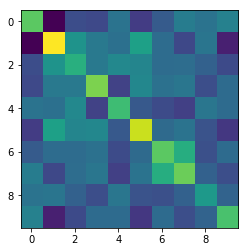

In [42]:
plt.imshow(A[:10, :10])

In [34]:
A_ii

array([[  1.00000000e+00,  -2.48106115e-16,  -2.37006595e-16,
         -5.22585447e-17,  -1.85181731e-16,   3.12033385e-16,
          5.76795556e-17,  -2.81404674e-16,  -1.50704102e-16,
         -1.23924308e-16],
       [ -2.48106115e-16,   1.00000000e+00,   7.34004871e-17,
          2.26069705e-16,  -1.73729846e-16,  -2.41868564e-16,
         -8.26433106e-17,  -1.21403538e-16,   2.23345648e-17,
          4.51841255e-17],
       [ -2.37006595e-16,   7.34004871e-17,   1.00000000e+00,
          3.89011739e-16,  -2.61943245e-16,  -7.30142401e-18,
          1.07769696e-16,  -1.74231289e-16,   1.03432887e-16,
         -1.00532646e-16],
       [ -5.22585447e-17,   2.26069705e-16,   3.89011739e-16,
          1.00000000e+00,   7.73903511e-16,   3.16695455e-16,
          2.74736831e-16,  -1.62901376e-16,  -6.09538461e-16,
          2.15430972e-16],
       [ -1.85181731e-16,  -1.73729846e-16,  -2.61943245e-16,
          7.73903511e-16,   1.00000000e+00,  -4.29872609e-16,
         -1.83013327e-16

In [37]:
A[:10, :10]

array([[  1.00000000e+00,  -2.19530611e-16,   2.11059435e-17,
          3.10132643e-16,  -2.09422120e-16,   2.49097143e-16,
         -2.06433549e-16,  -1.44067175e-16,  -1.07158138e-17,
          3.16619560e-15],
       [ -2.19530611e-16,   1.00000000e+00,  -1.81032964e-16,
          2.79310808e-16,  -5.32529614e-16,  -2.75746494e-16,
         -1.39581712e-16,   4.96124138e-16,   9.03267465e-17,
          6.51323613e-15],
       [  2.11059435e-17,  -1.81032964e-16,   1.00000000e+00,
         -1.42542940e-16,  -3.51035864e-17,   1.34692638e-16,
          1.72395133e-16,   3.55114540e-16,  -5.94175084e-16,
          1.53543356e-15],
       [  3.10132643e-16,   2.79310808e-16,  -1.42542940e-16,
          1.00000000e+00,   3.74575757e-16,  -1.19745048e-17,
         -1.60469757e-16,  -1.87591540e-16,   1.84763297e-17,
         -2.42693235e-15],
       [ -2.09422120e-16,  -5.32529614e-16,  -3.51035864e-17,
          3.74575757e-16,   1.00000000e+00,  -2.46850812e-16,
          2.51115239e-16

In [48]:
kappa = ms_solver._kappa[-1]
form = lambda u, v: assemble(kappa*dot(grad(u),grad(v))*dx(1))
for i in range(N_c):
    chi = ms_solver._overlap(i, i)
    dx = Measure('dx', domain=ms_solver.W.mesh(), subdomain_data=chi)
    A_ii = np.vectorize(form, [float])(psi[i, None], psi[i, :, None])
    break

In [19]:
f = MeshFunction('size_t', W.mesh(), W.mesh().topology().dim(), 0)

In [54]:
# psi_1 = project(ms_solver.psi_ms[0][0], ms_solver.V[0])
# psi_2 = project(ms_solver.psi_ms[1][0], ms_solver.V[1])


psi_1 = interpolate(Constant(1.), ms_solver.V[0])
psi_2 = interpolate(Constant(1.), ms_solver.V[1])

chi = ms_solver._overlap(0, 1)
dx = Measure('dx', domain=ms_solver.W, subdomain_data=chi)
assemble(dot(grad(psi_1), grad(psi_2)) * dx(1))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Moving new file over differing existing file:
src: /home/fenics/shared/src/jitfailure-ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5/error.log.89b3cd94b3104c7883678d3b8cbbb9e8
dst: /home/fenics/shared/src/jitfailure-ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5/error.log
backup: /home/fenics/shared/src/jitfailure-ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5/error.log.old
Backup file exists, overwriting.
------------------- Start compiler output ------------------------
/tmp/tmp9pwzi_w0/ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5.cpp: In member function ‘virtual void ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5_cell_integral_main_1::tabulate_tensor(double*, const double* const*, const double*, int) const’:
/tmp/tmp9pwzi_w0/ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5.cpp:102:18: error: redeclaration of ‘const double J_c0’
     const double J_c0 = coordinate_dofs[0] * FE11_C0_D01_Q1[0][0][0] + coordinate_dofs[2] * FE11_C0_D01_Q1[0][0][1];
                  ^~~

DijitsoError: Dijitso JIT compilation failed, see '/home/fenics/shared/src/jitfailure-ffc_form_a5e1f9c4935a7aabfc55096ff2cb3c36c00411d5' for details

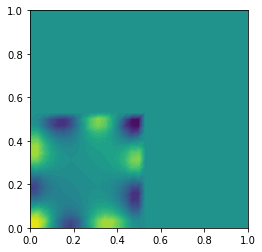

In [47]:
plot(v1)

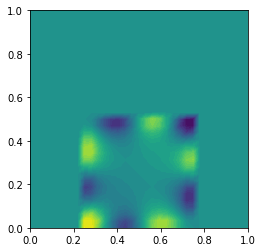

In [48]:
plot(v2)

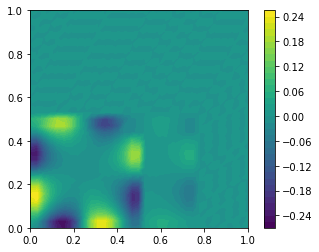

In [48]:
p = plot(v1 + v2)
plt.colorbar(p)

In [55]:
data = project(v1+v2, W).vector()[:]

In [60]:
v2d

array([528, 561, 593, ..., 495, 527, 560], dtype=int32)

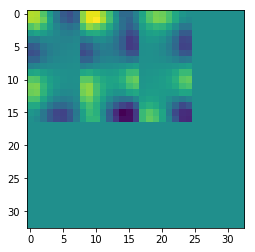

In [62]:
plt.imshow(data[v2d].reshape(33, 33))

In [14]:
W = FunctionSpace(UnitSquareMesh(32, 32), 'P', 1)
V = FunctionSpace(mom_mesh.part(0), 'P', 1)
Z = MultiMeshFunctionSpace(mom_mesh, 'P', 1)
v2d = vertex_to_dof_map(W)

In [4]:
V1 = FunctionSpace(mom_mesh.part(0), 'P', 1)
V2 = FunctionSpace(mom_mesh.part(1), 'P', 1)

N = V1.dim()
n = int(N ** .5)
I = np.arange(N).reshape(n, n)

v2d = vertex_to_dof_map(V1)
d2v = dof_to_vertex_map(V1)
cut1 = I[:, n//2:].flatten()
cut2 = I[:, :n//2+1].flatten()

u1, v1 = TrialFunction(V1), TestFunction(V1)
u2, v2 = TrialFunction(V2), TestFunction(V2)
kappa1 = setKappa(1e3, mask[:2*n_el+1, :2*n_el+1], V1)
kappa2 = setKappa(1e3, mask[:2*n_el+1, n_el:3*n_el+1], V2)
S1 = assemble(kappa1*dot(grad(u1), grad(v1)) * dx)
S2 = assemble(kappa2*dot(grad(u2), grad(v2)) * dx)

S1_ord = S1.array()[v2d[cut1], :][:, v2d[cut1]]
S2_ord = S2.array()[v2d[cut2], :][:, v2d[cut2]]
print(S1_ord.shape)

S1 = np.zeros((N, N))
S1[cut1[:, None], cut2] = S1_ord

NameError: name 'mask' is not defined

In [19]:
V1 = FunctionSpace(mom_mesh.part(0), 'P', 1)
V2 = FunctionSpace(mom_mesh.part(3), 'P', 1)

N = V1.dim()
n = int(N ** .5)
I = np.arange(N).reshape(n, n)

v2d = vertex_to_dof_map(V1)
d2v = dof_to_vertex_map(V1)

u1, v1 = TrialFunction(V1), TestFunction(V1)
kappa1 = setKappa(1e3, mask[:2*n_el+1, :2*n_el+1], V1)
S1 = assemble(kappa1*dot(grad(u1), grad(v1)) * dx)

S1_ord = S1.array()[v2d[-n*(n//2+1):], :][:, v2d[-n*(n//2+1):]]

S1 = np.zeros((N, N))
S1[-n*(n//2+1):, :n*(n//2+1)] = S1_ord

(153, 153)


In [33]:
N = 9
n = int(N ** .5)
I = np.arange(N).reshape(n, n)

cut1 = I[:, n//2:].flatten()
cut2 = I[:, :n//2+1].flatten()
S1 = np.zeros((N, N))
#S1[cut1[:, None], cut2] = 1
S1[-n*(n//2+1):, :n*(n//2+1)] = 1

In [25]:
u = TrialFunction(Z)
v = TestFunction(Z)
S = assemble_multimesh(kappa * dot(grad(u), grad(v)) * dx)
S = S.array()

In [10]:
f = Function(V1)
v = TestFunction(V1)
b = assemble(f * v * dx)
b.get_local()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [24]:
kappa = Expression('((abs(x[0]-.2) < tol) && (abs(x[1]-.1) < tol))? 1:0;', tol=15e-3, degree=1)

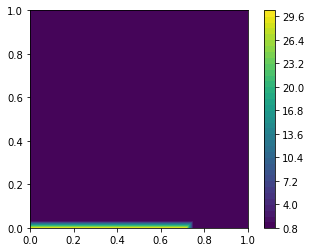

In [26]:
u = TrialFunction(W)
v = TestFunction(W)
mask = np.zeros((33, 33))
mask[0, :24] = 1
kappa = setKappa(30, mask, W)
p = plot(kappa)
plt.colorbar(p);

In [34]:
u = TrialFunction(V)
v = TestFunction(V)
S = assemble(dot(grad(u), grad(v)) * dx)

In [27]:
# f = Function(W)
# f.vector()[:] = 0
# f.vector()[2] = 1
f = Expression('((abs(x[0]-.2) < tol) && (abs(x[1]-.9) < tol))? 1:0;', tol=15e-3, degree=1)

In [28]:
f = interpolate(f, W)

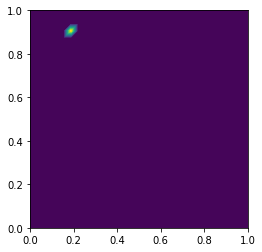

In [46]:
plot(f)

In [47]:
len(f.vector()[:])

1089

In [48]:
(f.vector()[:] > 0).nonzero()

(array([51]),)

In [49]:
(f.compute_vertex_values() > 0).nonzero()

(array([963]),)

In [229]:
vertex_to_dof_map(W)[155]

778

In [230]:
(f.compute_vertex_values() > 0).nonzero()

(array([155]),)

In [231]:
len(f.vector()[:])

1369

In [238]:
test = assemble(dot(grad(f), grad(v)) * dx)

In [243]:
test.array()

AttributeError: 'dolfin.cpp.la.Vector' object has no attribute 'array'

In [242]:
array[778]

4.0

In [11]:
SS = as_backend_type(S).mat()

In [17]:
A = scipy.sparse.csr_matrix(SS.getValuesCSR()[::-1])

In [20]:
A.transpose()

<1089x1089 sparse matrix of type '<class 'numpy.float64'>'
	with 7361 stored elements in Compressed Sparse Column format>

In [30]:
S.array().shape

(1089, 1089)

In [66]:
ms_solver._kappa[0]

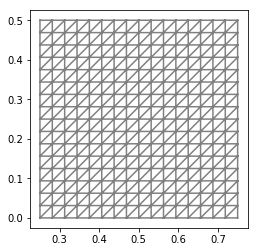

In [43]:
plot(V.mesh())

In [45]:
w = Function(W)
psi = project(ms_solver.psi_ms[0][0], V)
LagrangeInterpolator.interpolate(w, psi)

In [62]:
val = assemble(dot(grad(ms_solver.psi_ms[0][0]), grad(ms_solver.psi_ms[0][0])) * dx)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [63]:
val

0.999999999999999

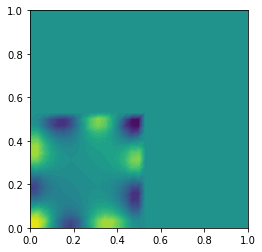

In [47]:
w

In [45]:
np.r_[C, psi.compute_vertex_values()].dtype

dtype('float64')

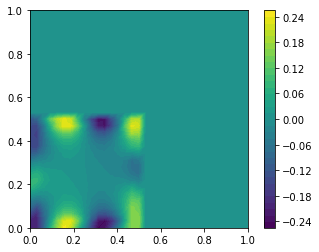

In [20]:
p = plot(func)
plt.colorbar(p)

In [ ]:
plot(U[10])

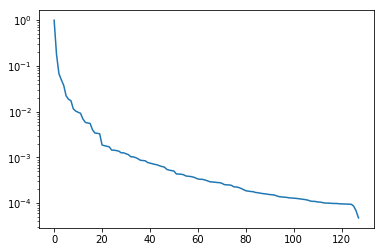

In [5]:
plt.plot(w[::-1] / w[-1])
plt.yscale('log')

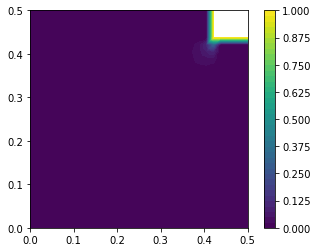

In [6]:
p = plot(ms_solver.U[0][-1])
plt.colorbar(p)

In [ ]:
plt.plot(w[::-1])

In [16]:
values = mask.flatten().astype('f4') * eta
for k in range(mom_mesh.num_parts()-1):
    i = k // (N_blocks-1)
    j = k % (N_blocks-1)
    loc_mask = mask[
        i*n_el:(i+2)*n_el+1,
        j*n_el:(j+2)*n_el+1]
    values = np.r_[values, loc_mask.flatten().astype('f4') * eta]
v.vector()[:] = values

False

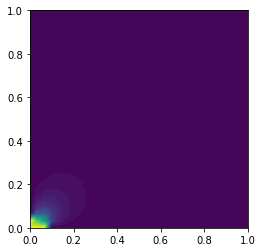

In [39]:
plot(U[1])

In [57]:
mesh = mom_mesh.part(0)
V = FunctionSpace(mesh, 'P', 1)
V_dg = FunctionSpace(mesh, 'DG', 0)
V_sub = FunctionSpace(mom_mesh.part(1), 'DG', 0)
chi = Function(V_dg)
kappa = setKappa(1e3, mask, V)

markers = MeshFunction('size_t', mesh, mesh.topology().dim(), 0)
LagrangeInterpolator.interpolate(chi, interpolate(Constant(1), V_sub))
markers.array()[:] = chi.vector().get_local()
dx = Measure('dx', domain=mesh, subdomain_data=markers)

u = TrialFunction(V)
v = TestFunction(V)

a = kappa * dot(grad(u), grad(v)) * dx
L = Constant(0.) * v * dx 
u = Function(V)
bmesh = BoundaryMesh(mom_mesh.part(1), 'local')
i=0
for src in bmesh.coordinates():
    bc1 = DirichletBC(V, Constant(0.), pn)
    pt = lambda x: boundary_1(x, src)
    bc2 = DirichletBC(V, Constant(1.), pt)
    bcs = [bc1, bc2]
    
    solve(a==L, u, bcs)
    
    if i>45: break
    i+=1

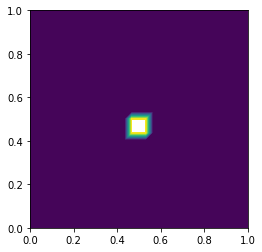

In [58]:
plot(u)

In [4]:
V = FunctionSpace(mesh, 'DG', 0)
V1 = FunctionSpace(submesh1, 'DG', 0)
chi1 = interpolate(Constant(1.), V1)
chi2 = interpolate(Constant(0.), V)

NameError: name 'submesh1' is not defined

In [33]:
out = make_submesh_local_to_global_map(V, V1)

In [34]:
chi2.vector()[out] = chi1.vector()

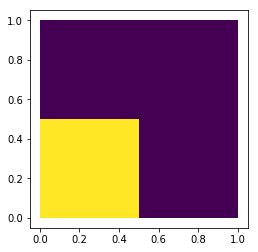

In [35]:
plot(chi2)

In [7]:
def zeroExtrapolate(V_sub, V_sup):
    sup_dofs = Function(V_sup)
    sup_dofs.vector()[:] = np.arange(V_sup.dim())
    sub_dofs = interpolate(u, V_sub)
    v2d = np.round(sub_dofs.vector().get_local())
    
    return v2d.astype(int)

In [43]:
from dolfin import *
import numpy as np
# parameters['allow_extrapolation'] = True

def overlap(mesh, mesh1, mesh2):
    '''
    Cell function of mesh marking mesh1 \cap mesh2
    '''
    V, V1, V2 = (FunctionSpace(m, 'DG', 0) for m in (mesh, mesh1, mesh2))
    
    chi1, chi2 = Function(V), Function(V)
    LagrangeInterpolator.interpolate(chi1, interpolate(Constant(1), V1))
    LagrangeInterpolator.interpolate(chi2, interpolate(Constant(1), V2))
    
    chi = chi1.vector().get_local() * chi2.vector().get_local()
    markers = MeshFunction('size_t', mesh, mesh.topology().dim(), 0)
    markers.array()[:] = chi

    return markers

mesh = UnitSquareMesh(32, 32)
submesh1 = UnitSquareMesh(16, 16)
submesh1.scale(.5)

submesh2 = UnitSquareMesh(16, 16)
submesh2.scale(.5)
submesh2.translate(Point(.25, 0))

W = FunctionSpace(mesh, 'P', 1)
W1 = FunctionSpace(submesh1, 'P', 1)
W2 = FunctionSpace(submesh2, 'P', 1)

w1 = interpolate(Constant(1), W1)
w2 = interpolate(Constant(2), W2)

chi = overlap(mesh, submesh1, submesh2)

dx = Measure('dx', domain=mesh, subdomain_data=chi)
print(assemble(w1 * w2 * dx(1)))

0.25000000000000006


In [67]:
V1 = ms_solver.V[0]
V2 = ms_solver.V[0]

W = ms_solver.W

w1 = project(ms_solver.psi_ms[0][2], V1)
w2 = project(ms_solver.psi_ms[0][1], V2)

w1W = Function(W)
LagrangeInterpolator.interpolate(w1W, w1)
w2W = Function(W)
LagrangeInterpolator.interpolate(w2W, w2)

chi = overlap(W.mesh(), V1.mesh(), V2.mesh())
dx = Measure('dx', domain=W.mesh(), subdomain_data=chi)
assemble(ms_solver._kappa[-1]*dot(grad(w1W), grad(w2W)) * dx(1))

-1.810329636848726e-16

In [45]:
v1 = Function(W)
v2 = Function(W)
LagrangeInterpolator.interpolate(v1, w1)
LagrangeInterpolator.interpolate(v2, w2)
assemble(v1 * v2 * dx)

0.28710937500000017

In [46]:
from dolfin import *
import numpy as np
# parameters['allow_extrapolation'] = True

def overlap(mesh, mesh1, mesh2):
    '''Cell function of mesh marking mesh1 \cap mesh2'''
    meshes = (mesh, mesh1, mesh2)
    V, V1, V2 = (FunctionSpace(m, 'DG', 0) for m in meshes)

    chi1, chi2 = Function(V), Function(V)
    LagrangeInterpolator.interpolate(chi1, interpolate(Constant(1), V1))
    LagrangeInterpolator.interpolate(chi2, interpolate(Constant(1), V2))
    # Intersect
    chi = chi1.vector().get_local() * chi2.vector().get_local()
    chi = np.fromiter(chi, dtype='uintp')
    # As cell function
    f = MeshFunction('size_t', mesh, mesh.topology().dim(), 0)
    f.array()[:] = chi

    return f

mesh = UnitSquareMesh(32, 32)
submesh1 = UnitSquareMesh(8, 8)
submesh1.scale(.5)

submesh2 = UnitSquareMesh(8, 8)
submesh2.scale(.5)
submesh2.translate(Point(.25, 0))

W = FunctionSpace(mesh, 'P', 1)
W1 = FunctionSpace(submesh1, 'P', 1)
W2 = FunctionSpace(submesh2, 'P', 1)

w1 = interpolate(Constant(1), W1)
w2 = interpolate(Constant(2), W2)

w1W, w2W = Function(W), Function(W)
LagrangeInterpolator.interpolate(w1W, w1)
LagrangeInterpolator.interpolate(w2W, w2)

chi = overlap(mesh, submesh1, submesh2)

dx = Measure('dx', domain=mesh, subdomain_data=chi)
print(assemble(w1W * w2W * dx(1)))

0.25000000000000006


In [50]:
pairs

AttributeError: 'numpy.ndarray' object has no attribute 'unbind'

In [54]:
eta = 1e3
N_blocks = 4
block_size = 1./N_blocks

def in_neighborhood(x, i, j):
    predicat1 = i*block_size-(i>0)*tol <= x[0] <= (i+2)*block_size+(i<2)*tol
    predicat2 = j*block_size-(j>0)*tol <= x[1] <= (j+2)*block_size+(j<2)*tol
    return predicat1 and predicat2

markers = MeshFunction('size_t', mesh, mesh.topology().dim())
blocks = np.empty((N_blocks-1)*(N_blocks-1), dtype='O')
build = np.vectorize(assemble)

for index in range((N_blocks-1)*(N_blocks-1)):
    markers.set_all(0)
    i = index // (N_blocks-1)
    j = index % (N_blocks-1)
    blocks[index] = AutoSubDomain(lambda x: in_neighborhood(x, i, j))
    blocks[index].mark(markers, 1)
    dx = Measure('dx', domain=mesh, subdomain_data=markers)
    submesh = SubMesh(mesh, markers, 1)
    bmesh = BoundaryMesh(submesh, 'local')
    
    U, DU = [], []
    u = TrialFunction(V)
    v = TestFunction(V)

    a = kappa * dot(grad(u), grad(v)) * dx(1)
    L = Constant(0.) * v * dx(1)

    for src in bmesh.coordinates():
        pn = lambda x, on_boundary: boundary_2(x, src, on_boundary)
        bc2 = DirichletBC(V, Constant(0.), pn)
        pt = lambda x: boundary_1(x, src)
        bc1 = DirichletBC(V, Constant(1.), pt)
        bc = [bc1, bc2]

        u = Function(V)
        solve(a == L, u, bc)
        U.append(u)
        DU.append(grad(u))
        
    A = build(kappa * np.outer(U, U) * dx(1))  # mass matrix
    S = build(kappa * np.tensordot(DU, DU, [1, 1]) * dx(1))  # stiffness matrix
    break

AttributeError: module 'dolfin.mesh' has no attribute 'topology'

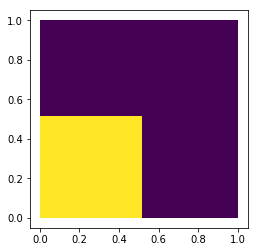

In [44]:
plot(markers)

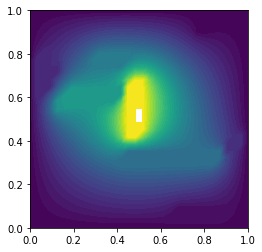

In [45]:
plot(u);

In [25]:
U, DU = [], []

u = TrialFunction(V)
v = TestFunction(V)

a = kappa * dot(grad(u), grad(v)) * dx
L = Constant(0.) * v * dx

for src in bmesh.coordinates():
    pn = lambda x, on_boundary: boundary_2(x, src, on_boundary)
    bc2 = DirichletBC(V, Constant(0.), pn)
    pt = lambda x: boundary_1(x, src)
    bc1 = DirichletBC(V, Constant(1.), pt)
    bc = [bc1, bc2]
    
    u = Function(V)
    solve(a == L, u, bc)
    U.append(u)
    DU.append(grad(u))

In [27]:
build = np.vectorize(assemble)
A = build(kappa * np.outer(U, U) * dx)  # mass matrix
S = build(kappa * np.tensordot(DU, DU, [1, 1]) * dx)  # stiffness matrix

## Eigenvalues

In [109]:
#w, v = eigh(A, S)
w /= w[-1]

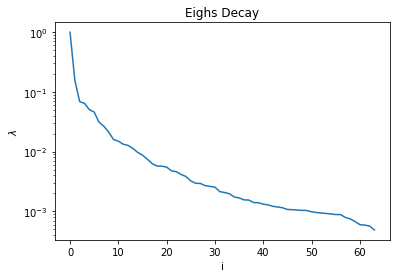

In [110]:
plt.plot(w[::-1])
plt.title("Eighs Decay")
plt.ylabel(r'$\lambda$')
plt.yscale('log')
plt.xlabel('i');

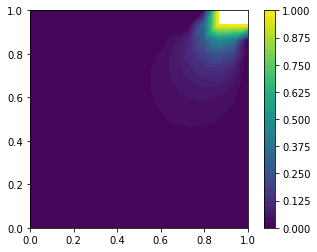

In [30]:
# plot the solution for the last bcs
p = plot(u)
plt.colorbar(p);

## Eigenfunctions

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


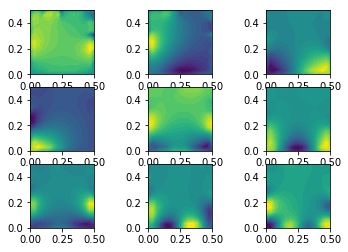

In [111]:
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plot(np.dot(U, v[:, -i]));

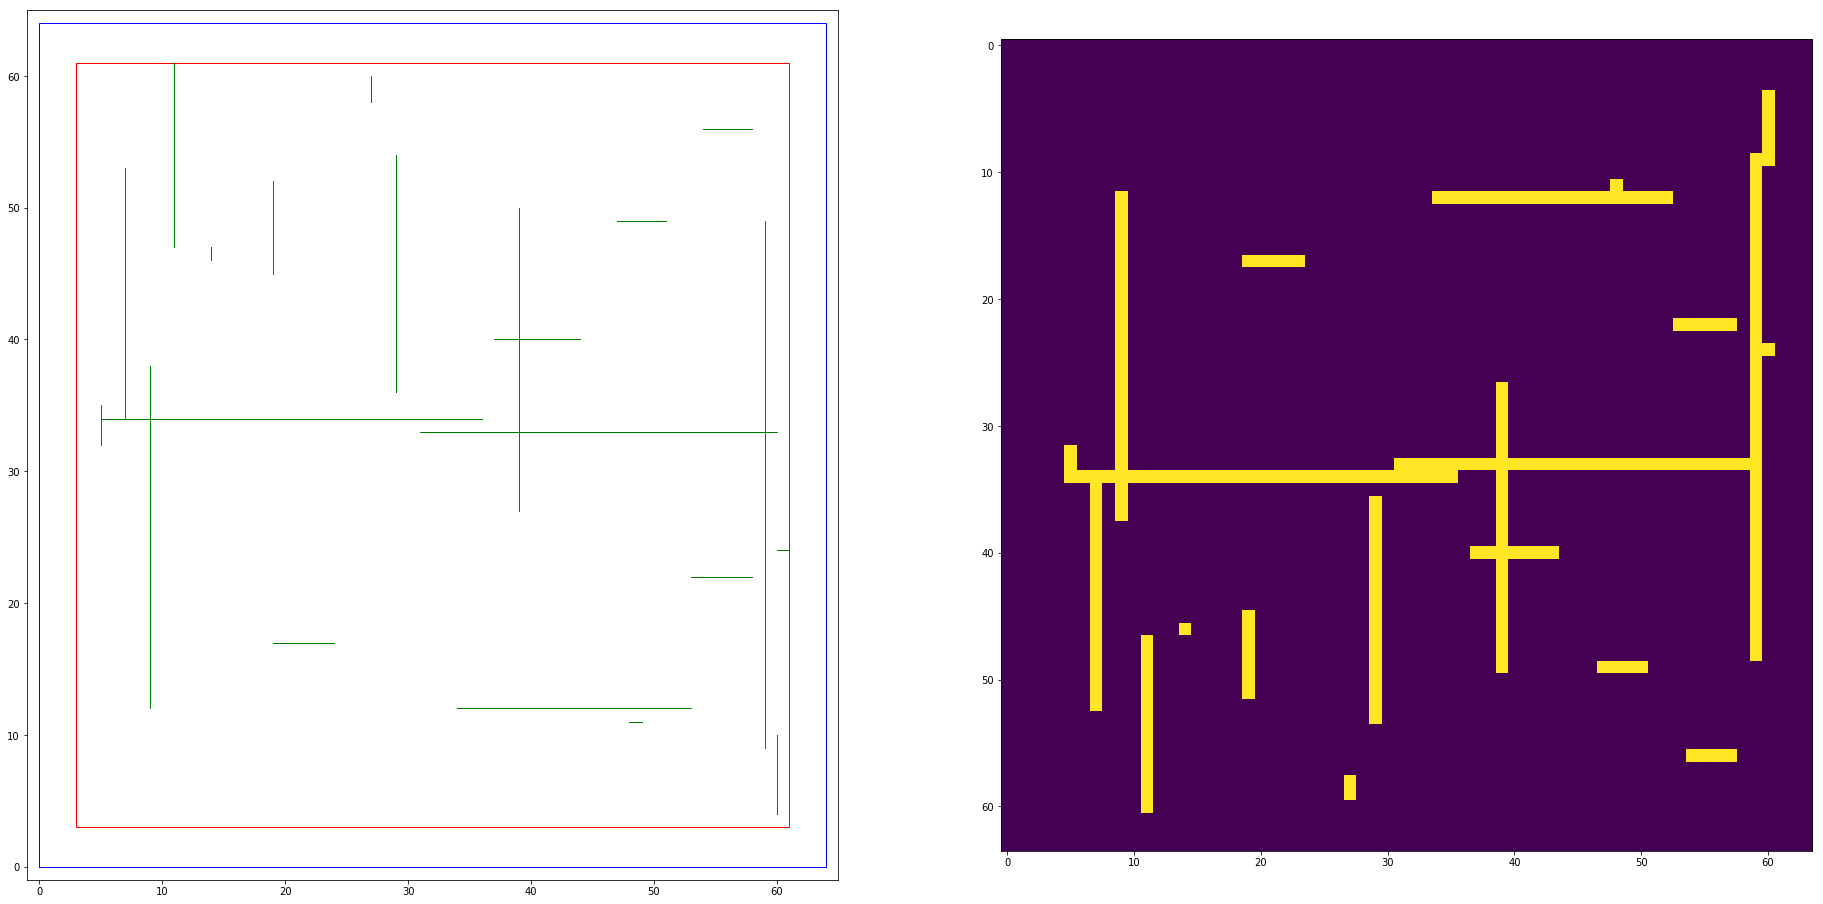

In [13]:
# Define the global coefficient
N_el = 63 
mesh = UnitSquareMesh(N_el, N_el)
bmesh = BoundaryMesh(mesh, "exterior", True)
V = FunctionSpace(mesh,'P', 1)

win = N_el // 16
side = N_el + 1 - 2 * win

# Set number of channels
n_strips = N_el // 3
n_ver = np.random.binomial(n_strips, p=.5)
n_hor = n_strips - n_ver

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))
ax1.set_xlim(-1, N_el+2)
ax1.set_ylim(-1, N_el+2)
ax1.add_patch(Rectangle((0, 0), N_el+1, N_el+1, lw=1, fc='none', ec='b'));
ax1.add_patch(Rectangle((win, win), side, side, lw=1, fc='none', ec='r'));

mask = np.zeros((N_el+1, N_el+1), dtype='bool')
for pos, n_lines in zip((0, 1), (n_ver, n_hor)):
    ends = [None] * 2
    ends[0] = np.random.choice(side, n_lines, replace=False) + win
    ends[1] = np.random.choice(side, n_lines, replace=False) + win
    lengths = np.ceil(np.random.rand(n_lines) * (side+win-ends[pos])).astype('int')
    for l, x1, x2 in zip(lengths, *ends):
        if pos:
        # vertical lines
            xdata = [x1] 
            ydata = [x2, x2+l]
            mask[x2:x2+l, x1] = True
            # mask[-x2-l:-x2, x1] = True
        else: 
        # horizontal lines
            xdata = [x1, x1+l]
            ydata = [x2]
            mask[x2, x1:x1+l] = True
            # mask[-x2, x1:x1+l] = True

        ax1.add_line(Line2D(xdata, ydata, lw=1, c='g'))
ax2.imshow(mask);

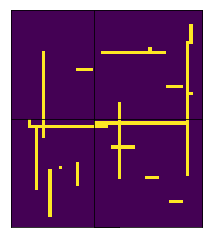

In [14]:
n_el = 15
n_blocks = (N_el+1) // (n_el+1) - 1
fig, ax = plt.subplots((n_blocks+1)//2, (n_blocks+1)//2)
coarse_ids = np.arange(0, N_el-2*n_el, n_el+1)
for i in np.arange(n_blocks):
    for j in np.arange(n_blocks):
        if not (i%2) and not (j%2):
            ax[i//2, j//2].set_xticks([])
            ax[i//2, j//2].set_yticks([])
            x = coarse_ids[j]
            y = coarse_ids[i]
            ax[i//2, j//2].imshow(mask[y:y+2*(n_el+1), x:x+2*(n_el+1)]);
plt.subplots_adjust(hspace=0, wspace=-.67)

In [41]:
n_el = 15
n_blocks = (N_el+1) // (n_el+1) - 1
coarse_ids = np.arange(0, N_el-2*n_el, n_el+1)
M_off = 10

Psi = []
snap_space = []
build = np.vectorize(assemble)
mesh = UnitSquareMesh(2*n_el+1, 2*n_el+1)
bmesh = BoundaryMesh(mesh, "exterior", True)
V = FunctionSpace(mesh, 'P', 1)
v2d = vertex_to_dof_map(V)
for i in np.arange(n_blocks):
    for j in np.arange(n_blocks):
        x = coarse_ids[j]
        y = coarse_ids[i]
        loc_mask = mask[y:y+2*(n_el+1), x:x+2*(n_el+1)]
        
        kappa = Function(V)
        dofs, = loc_mask.flatten().nonzero()
        kappa.vector()[:] = 1
        kappa.vector()[v2d[dofs]] = eta
        
        U, DU = [], []

        u = TrialFunction(V)
        v = TestFunction(V)

        a = kappa * dot(grad(u), grad(v)) * dx
        L = Constant(0.) * v * dx

        for src in bmesh.coordinates():
            pn = lambda x, on_boundary: boundary_2(x, src, on_boundary)
            bc2 = DirichletBC(V, Constant(0.), pn)
            pt = lambda x: boundary_1(x, src)
            bc1 = DirichletBC(V, Constant(1.), pt)
            bc = [bc1, bc2]

            u = Function(V)
            solve(a == L, u, bc)
            U.append(u)
            DU.append(grad(u))
            
        snap_space.append(U)
        A = build(kappa * np.outer(U, U) * dx)
        S = build(kappa * np.tensordot(DU, DU, [1, 1]) * dx)
        w, v = eigh(A, S)
        Psi.append(v[:, -M_off:])
    break

i: 0
j: 0
j: 1
j: 2


In [62]:
tmp = build(np.outer(snap_space[0], snap_space[1]) * dx)

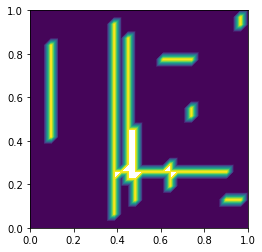

In [119]:
mesh = UnitSquareMesh(31, 31)
V = FunctionSpace(mesh, 'P', 1)
kappa = Function(V)
v2d = vertex_to_dof_map(V)
dofs, = mask[:32, :32].flatten().nonzero()
kappa.vector()[:] = 1
kappa.vector()[v2d[dofs]] = eta
plot(kappa);

In [120]:
len(kappa.vector()[:])

1024

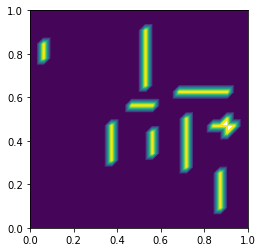

In [3]:
eta = 1e3

kappa = Function(V)
v2d = vertex_to_dof_map(V)
dofs, = mask.flatten().nonzero()
kappa.vector()[:] = 1
kappa.vector()[v2d[dofs]] = eta
plot(kappa);

---
## Draft

## Permeability mask

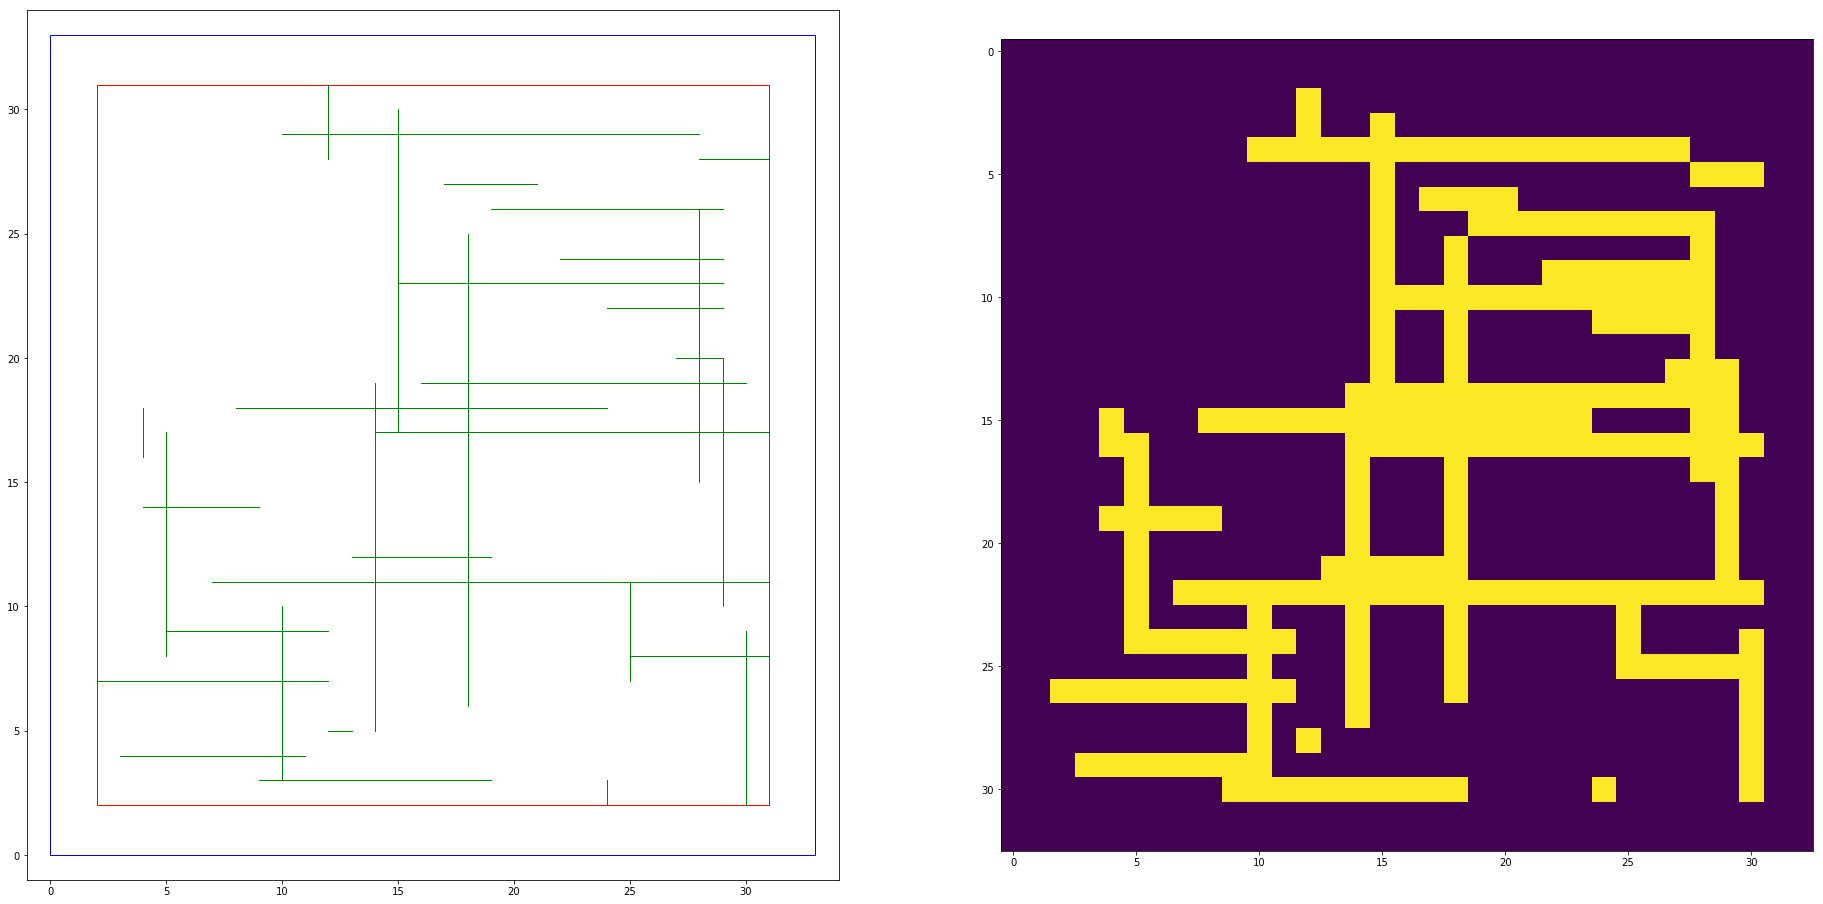

In [83]:
# Define the global coefficient
n_el = 32
mesh = UnitSquareMesh(n_el, n_el)
V = FunctionSpace(mesh,'P',1)

win = n_el // 16
side = n_el + 1 - 2 * win

# Set number of channels
n_strips = n_el
n_ver = np.random.binomial(n_strips, p=.5)
n_hor = n_strips - n_ver

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))
ax1.set_xlim(-1, n_el+2)
ax1.set_ylim(-1, n_el+2)
ax1.add_patch(Rectangle((0, 0), n_el+1, n_el+1, lw=1, fc='none', ec='b'));
ax1.add_patch(Rectangle((win, win), side, side, lw=1, fc='none', ec='r'));

box_mask = np.zeros((side, side), dtype='bool')
for pos, n_lines in zip((0, 1), (n_ver, n_hor)):
    ends = [None] * 2
    ends[0] = np.random.choice(side, n_lines, replace=False)
    ends[1] = np.random.choice(side, n_lines, replace=False)
    lengths = np.ceil(np.random.rand(n_lines) * (side - ends[pos])).astype('int')
    for l, x1, x2 in zip(lengths, *ends):
        if pos:
            xdata = [x1+win] 
            ydata = [side-x2+win, side-x2-l+win]
            box_mask[x2:x2+l, x1] = True 
        else: 
            xdata = [x1+win, x1+l+win]
            ydata = [side-x2+win]
            box_mask[x2, x1:x1+l] = True

        ax1.add_line(Line2D(xdata, ydata, lw=1, c='g'))

mask = np.zeros((n_el+1, n_el+1), dtype='bool')
mask[win:-win, win:-win] = box_mask
# mask = mask.repeat(N, 0).repeat(N, 1)
ax2.imshow(mask);

```python
tol = 5e-3
def boundary_1(x, src):
    return (src[0] - x[0]) ** 2 + (src[1] - x[1]) ** 2 <= tol

def boundary_2(x, src):
    return (src[0] - x[0]) ** 2 + (src[1] - x[1]) ** 2  > tol
```

In [155]:
U, DU = [], []
alpha = (1. / tol) ** 2

CNT  = 0
stop = None
prev = None
cumul = []
check = False

_u = TrialFunction(V)
_v = TestFunction(V)

a = kappa * dot(grad(_u), grad(_v)) * dx
L = Constant(0.) * _v * dx

for src in bmesh.coordinates():
    pn = lambda x, on_boundary: \
        boundary_2(x, src, on_boundary)
    bc2 = DirichletBC(V, Constant(0.), pn)
    
    pt = lambda x: boundary_1(x, src)

    u_bc = Constant(1.)
    bc1 = DirichletBC(V, u_bc, pt)

    bc = [bc1, bc2]
    
    if check:
        _u = TrialFunction(V)
        _v = TestFunction(V)
        a = dot(grad(_u), grad(_v)) * dx
    # ^^^^^ check that matrix A does not change
        curr = assemble(a).array()
        if prev is not None:
            to_add = np.allclose(curr, prev)
            if not to_add:
                print("'A' has changed")
                break
            cumul.append(to_add)

        prev = curr            
    # ^^^^^ ------------------------------------
    
    u = Function(V)

    solve(a == L, u, bc)
    U.append(u)
    DU.append(grad(u))
    
    # early stop (to plot the chosen solution)
    CNT += 1
    if stop and CNT >= stop:
        break

```python
tol = 1 / n_el
def boundary_1(p, src):
    for vx, vy in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        if near(src[0], vx) and near(src[1], vy):
            predicat_1 = near(p[0], src[0], tol)
            predicat_2 = near(p[1], src[1], tol)
            
            return predicat_1 & predicat_2
        
    for xy, tb in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        if near(src[xy], tb):
            predicat_1 = near(p[xy], tb)
            predicat_2 = near(p[1-xy], src[1-xy], tol)

            return predicat_1 & predicat_2
        
def boundary_2(x, src, on_boundary):
    return on_boundary and not boundary_1(x, src)
```

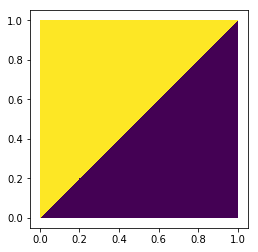

In [21]:
mesh = UnitSquareMesh(10, 10)

domains = MeshFunction('size_t', mesh, 2)
for cell in cells(mesh):
    M = cell.midpoint()
    if M.y() > M.x():
        domains[cell] = 1

plot(domains)

V = FunctionSpace(mesh, 'CG', 1)
u = TrialFunction(V)
v = TestFunction(V)

f0 = Constant(0)  # source to be used in domain 0
f1 = Constant(1)  # source to be usde in domain 1

dx = Measure('dx', mesh, subdomain_data=domains)
a = inner(grad(u), grad(v))*dx('everywhere')
# Inluclude sources
L = inner(f0, v)*dx(0) + inner(f1, v)*dx(1)
bc = DirichletBC(V, Constant(0), DomainBoundary())
uh = Function(V)

solve(a == L, uh, bc)
#plot(uh)

```python
tol = 1 / n_el
k_0 = 100.
k_1 = .01
kappa = Expression(
    "(((.4 < x[0]) && (x[0] < .5)) && "
    "((.5 < x[1]) && (x[1] < .6))) ? k_0: k_1", 
    degree=0, tol=tol, k_0=k_0, k_1=k_1
)
    
#add to block with for loop if switch to smooth boundaries
"""u_bc = Expression(
    'alpha * exp(-1. / (1 - alpha * ((x[0] - x_0) * '
    '(x[0] - x_0)+ (x[1] - x_1) * (x[1] - x_1))))',
    degree=2, alpha = alpha, x_0 = src[0], x_1 = src[1]
)"""
```

In [204]:
nodal_values_u = u.vector()
array_u = nodal_values_u.get_local()

In [9]:
tmp = as_backend_type(assemble(a)).mat()
S = csr_matrix(tmp.getValuesCSR()[::-1], shape=tmp.size)